In this notebook different quantisation methods and distance metrics for Facial Recognition will be compared both on accuracy and execution time. 

The Quantisation methods include:
- Scalar Quantisation
- TensorFlow Quantisation

The distance metrics include:
- Cosine Similarity
- Euclidean Distance

Below are the necassary import to run the code.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tensorflow warnings https://stackoverflow.com/a/40871012
from deepface import DeepFace
import subprocess
import numpy as np
from decimal import Decimal # for proper rounding
import random
import time
import pandas as pd
from datetime import datetime
import struct
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statistics



# CONSTANTS
EXECUTABLE_PATH = "ABY/build/bin"
INPUT_FILE_NAME = "input_vecs.txt"
EXECUTABLE_NAME_SCENARIO = 'cos_dist_copy'
CMD_SCENARIO = f"./{EXECUTABLE_NAME_SCENARIO} -r 1 -f {INPUT_FILE_NAME} & (./{EXECUTABLE_NAME_SCENARIO} -r 0 -f {INPUT_FILE_NAME} 2>&1 > /dev/null)"

# random number generator
rng = np.random.default_rng()

Below the basic functions to get embeddings and random images as used in Kamil's thesis will be put.

In [ ]:
def run_sfe(x, y, y_0, y_1):
    # write the original 2 vectors to a file (second vector used only for verification)
    with open(f"{EXECUTABLE_PATH}/{INPUT_FILE_NAME}", 'w') as f:
        for x_i, y_i in zip(x, y):
            f.write(f"{x_i} {y_i}\n")
            
    # write the shares into separate files
    with open(f"{EXECUTABLE_PATH}/share0.txt", 'w') as f:
        for i in y_0:
            f.write(f"{i}\n")
    with open(f"{EXECUTABLE_PATH}/share1.txt", 'w') as f:
        for i in y_1:
            f.write(f"{i}\n")
            
    # execute the ABY cos sim computation
    output = subprocess.run(CMD_SCENARIO, shell=True, capture_output=True, text=True, cwd=EXECUTABLE_PATH)
    assert (output.returncode == 0) # make sure the process executed successfully
    
    return output

def get_embedding(imagepath):
    return DeepFace.represent(img_path = imagepath, model_name="SFace", enforce_detection=True)[0]["embedding"]

def get_cos_dist_numpy(x, y):
    return 1 - np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))
    
def get_cos_dist_nom(x, y):
    return 1 - np.dot(x, y)
        
def get_two_random_embeddings(same_person):
    """Get two random embeddings of either the same person or two different people out of all the images available"""
    people = os.listdir('lfw') # list of all people that have images
    people_with_multiple_images = [p for p in people if len(os.listdir(f"lfw/{p}")) > 1] # list of people with more than one image in folder
    embedding1, embedding2 = None, None # face embeddings
    while embedding1 is None or embedding2 is None: # try until the chosen images have detectable faces
        try:
            if same_person:
                # same person should have more than one image (we might still end up choosing the same image of that person with prob 1/n, but that's ok)
                person1 = random.choice(people_with_multiple_images)
                person2 = person1
            else:
                # two persons chosen should be different
                person1 = random.choice(people)
                person2 = random.choice([p for p in people if p != person1])
            # get two random images
            img1 = f"lfw/{person1}/{random.choice(os.listdir(f'lfw/{person1}'))}"
            img2 = f"lfw/{person2}/{random.choice(os.listdir(f'lfw/{person2}'))}"
            # try to extract embeddings from both images
            embedding1 = get_embedding(img1)
            embedding2 = get_embedding(img2)
        except Exception as e:
            # failed to detect faces in images, try again
            # print(e)
            pass
    return np.array(embedding1), np.array(embedding2), img1,img2

def write_two_random_vecs(as_int=False):
    x, y = get_two_random_embeddings(False)
    if as_int:
        x = x.astype(int)
        y = y.astype(int)
    with open(f"{EXECUTABLE_PATH}/{INPUT_FILE_NAME}", 'w') as f:
        for x_i, y_i in zip(x, y):
            f.write(f"{x_i} {y_i}\n")

def get_two_random_images(same_person):
    """Get two random embeddings of either the same person or two different people out of all the images available"""
    people = os.listdir('lfw') # list of all people that have images
    people_with_multiple_images = [p for p in people if len(os.listdir(f"lfw/{p}")) > 1] # list of people with more than one image in folder
    img1, img2 = None, None # face embeddings
    while img1 is None or img2 is None: # try until the chosen images have detectable faces
        try:
            if same_person:
                # same person should have more than one image (we might still end up choosing the same image of that person with prob 1/n, but that's ok)
                person1 = random.choice(people_with_multiple_images)
                person2 = person1
            else:
                # two persons chosen should be different
                person1 = random.choice(people)
                person2 = random.choice([p for p in people if p != person1])
            # get two random images
            img1 = f"lfw/{person1}/{random.choice(os.listdir(f'lfw/{person1}'))}"
            img2 = f"lfw/{person2}/{random.choice(os.listdir(f'lfw/{person2}'))}"
        except Exception as e:
            # failed to detect faces in images, try again
            # print(e)
            pass

    return img1,img2

Below are the functions for euclidean distance we created and adpapted versions of get_two_random_embeddings and get_embedding for facenet.

In [3]:
def euclidean_distance(x, y):
    """
    Compute the euclidean distance between two vectors using numpy
    """
    return np.linalg.norm(np.array(x) - np.array(y))

def get_two_random_embeddings_facenet(same_person):
    """Get two random embeddings of either the same person or two different people out of all the images available"""
    people = os.listdir('lfw') # list of all people that have images
    people_with_multiple_images = [p for p in people if len(os.listdir(f"lfw/{p}")) > 1] # list of people with more than one image in folder
    embedding1, embedding2 = None, None # face embeddings
    while embedding1 is None or embedding2 is None: # try until the chosen images have detectable faces
        try:
            if same_person:
                # same person should have more than one image (we might still end up choosing the same image of that person with prob 1/n, but that's ok)
                person1 = random.choice(people_with_multiple_images)
                person2 = person1
            else:
                # two persons chosen should be different
                person1 = random.choice(people)
                person2 = random.choice([p for p in people if p != person1])
            # get two random images
            img1 = f"lfw/{person1}/{random.choice(os.listdir(f'lfw/{person1}'))}"
            img2 = f"lfw/{person2}/{random.choice(os.listdir(f'lfw/{person2}'))}"
            # try to extract embeddings from both images
            embedding1 = get_embedding_facenet(img1)
            embedding2 = get_embedding_facenet(img2)
        except Exception as e:
            # failed to detect faces in images, try again
            # print(e)
            pass
    return np.array(embedding1), np.array(embedding2), img1,img2

def get_embedding_facenet(imagepath):
    return DeepFace.represent(img_path = imagepath, model_name="Facenet", enforce_detection=True)[0]["embedding"]

Below the quantisation methods are defined.

In [12]:
def scalar_quantization(embedding, num_bits, coverage_percentage):
    max_val = np.max(embedding)
    min_val = np.min(embedding)
    
    # Calculate the desired range to cover the specified percentage of values
    coverage_range = np.percentile(embedding, [100 - coverage_percentage, coverage_percentage])
    desired_max = coverage_range[1]
    desired_min = coverage_range[0]
    
    # Adjust the range dynamically based on the desired range
    scale_factor = (max_val - min_val) / (desired_max - desired_min)
    adjusted_max = max_val / scale_factor
    adjusted_min = min_val / scale_factor

    if num_bits <= 8:
        dtype = np.int8
    elif num_bits <= 16:
        dtype = np.int16
    elif num_bits <= 32:
        dtype = np.int32
    elif num_bits <= 64:
        dtype = np.int64
    else:
        dtype = np.int128
    
    
    quantized_embedding = ((embedding - adjusted_min) / (adjusted_max - adjusted_min) * (2**num_bits - 1)).astype(dtype)
    return quantized_embedding

def quantize_tensor(input_tensor, T=tf.qint8, mode='MIN_COMBINED', round_mode='HALF_AWAY_FROM_ZERO', name=None, narrow_range=False, axis=None, ensure_minimum_range=0.01):
    quantized_tensor, _, _ = tf.quantization.quantize(
        input=input_tensor,
        min_range= np.min(input_tensor),
        max_range=np.max(input_tensor),
        T=T,
        mode=mode,
        round_mode=round_mode,
        name=name,
        narrow_range=narrow_range,
        axis=axis,
        ensure_minimum_range=ensure_minimum_range
    )
    return quantized_tensor.numpy()


Here we test if quantisation works

In [13]:
embedding1 = get_embedding("lfw/George_W_Bush/George_W_Bush_0001.jpg")
embedding2 = get_embedding("lfw/George_W_Bush/George_W_Bush_0002.jpg")
get_cos_dist_numpy(embedding1, embedding2)
embedding1_quant=scalar_quantization(embedding1,32,100)
embedding2_quant=quantize_tensor(embedding2)
print("size before scalar quantisation:" ,sys.getsizeof(embedding1), ", size after scalar quantisation:",sys.getsizeof(embedding1_quant)) 
print("size before tensor quantisation:", sys.getsizeof(embedding2), ", size after tensor quantisation:",sys.getsizeof(embedding2_quant)) 
print("the type of the elements in the scalar quantisation is:", type(embedding1_quant[0]), "in the non quantised embedding it was:",type(embedding1[0]))
print("the type of the elements in the tensor quantisation is:", type(embedding2_quant[0]), "in the non quantised embedding it was:",type(embedding2[0]))

size before scalar quantisation: 1080 , size after scalar quantisation: 624
size before tensor quantisation: 1080 , size after tensor quantisation: 240
the type of the elements in the scalar quantisation is: <class 'numpy.int32'> in the non quantised embedding it was: <class 'float'>
the type of the elements in the tensor quantisation is: <class 'numpy.int8'> in the non quantised embedding it was: <class 'float'>


Below are two functions to compare Facenet and Sface accuracy. One for Euclidean Distance and one for Cosine Similarity. The code to create a visual representation for this comparison is also included.

In [43]:
coverage=100 # coverage % for scalar

In [71]:
#compare accuracies SFace Facenet euclidean

m=1000 #number of pairs to compare 
c_t=0 #counter
w_t=0 #counter
c_s=0 #counter
w_s=0 #counter

c_s16=0 #counter
w_s16=0 #counter

c_s32=0 #counter
w_s32=0 #counter

c_s64=0 #counter
w_s64=0 #counter

c=0 #counter
w=0 #counter
c_t_s=0 #counter
w_t_s=0 #counter

c_s_s=0 #counter
w_s_s=0 #counter

c_s_s16=0 #counter
w_s_s16=0 #counter

c_s_s32=0 #counter
w_s_s32=0 #counter

c_s_s64=0 #counter
w_s_s64=0 #counter

c_s_s128=0 #counter
w_s_s128=0 #counter

c_ss=0 #counter
w_ss=0 #counter
fn_threshold_cos=0.4
sf_threshold_cos=0.593
fn_threshold=10
sf_threshold=10.734   
for i in range(0,m):
    print(i) #check if it is running
    n=random.choice([True, False])
    #facenet
    a, b, imga, imgb = get_two_random_embeddings_facenet(same_person=n)
    a_q_tensor=quantize_tensor(a)
    b_q_tensor=quantize_tensor(b)
    a_qn_t = a_q_tensor / np.linalg.norm(a_q_tensor)
    b_qn_t = b_q_tensor / np.linalg.norm(b_q_tensor)

    a_quant=scalar_quantization(a, 8, coverage)
    b_quant=scalar_quantization(b, 8, coverage)
    a_qn_s = a_quant / np.linalg.norm(a_quant)
    b_qn_s = b_quant / np.linalg.norm(b_quant)

    a_quant16=scalar_quantization(a, 16, coverage)
    b_quant16=scalar_quantization(b, 16, coverage)
    a_qn_s16 = a_quant16 / np.linalg.norm(a_quant16)
    b_qn_s16 = b_quant16 / np.linalg.norm(b_quant16)

    a_quant32=scalar_quantization(a, 32, coverage)
    b_quant32=scalar_quantization(b, 32, coverage)
    a_qn_s32 = a_quant32 / np.linalg.norm(a_quant32)
    b_qn_s32 = b_quant32 / np.linalg.norm(b_quant32)

    a_quant64=scalar_quantization(a, 64, coverage)
    b_quant64=scalar_quantization(b, 64, coverage)
    a_qn_s64 = a_quant64 / np.linalg.norm(a_quant64)
    b_qn_s64 = b_quant64 / np.linalg.norm(b_quant64)


    a_n=a / np.linalg.norm(a)
    b_n=b / np.linalg.norm(b)
    
    #sface
    a_s=get_embedding(imga)
    b_s=get_embedding(imgb)
    
    a_q_tensor_s=quantize_tensor(a_s)
    b_q_tensor_s=quantize_tensor(b_s)
    a_qn_t_s = a_q_tensor_s / np.linalg.norm(a_q_tensor_s)
    b_qn_t_s = b_q_tensor_s / np.linalg.norm(b_q_tensor_s)

    a_quant_s=scalar_quantization(a_s, 8, coverage)
    b_quant_s=scalar_quantization(b_s, 8, coverage)
    a_qn_s_s = a_quant_s / np.linalg.norm(a_quant)
    b_qn_s_s = b_quant_s / np.linalg.norm(b_quant)

    a_quant_s16=scalar_quantization(a_s, 16, coverage)
    b_quant_s16=scalar_quantization(b_s, 16, coverage)
    a_qn_s_s16 = a_quant_s16 / np.linalg.norm(a_quant16)
    b_qn_s_s16 = b_quant_s16 / np.linalg.norm(b_quant16)

    a_quant_s32=scalar_quantization(a_s, 32, coverage)
    b_quant_s32=scalar_quantization(b_s, 32, coverage)
    a_qn_s_s32= a_quant_s32 / np.linalg.norm(a_quant32)
    b_qn_s_s32 = b_quant_s32 / np.linalg.norm(b_quant32)

    a_quant_s64=scalar_quantization(a_s, 64, coverage)
    b_quant_s64=scalar_quantization(b_s, 64, coverage)
    a_qn_s_s64 = a_quant_s64 / np.linalg.norm(a_quant64)
    b_qn_s_s64 = b_quant_s64 / np.linalg.norm(b_quant64)


    a_n_s=a_s / np.linalg.norm(a_s)
    b_n_s=b_s / np.linalg.norm(b_s)
    
    if n==True:
        if euclidean_distance(a_qn_t, b_qn_t)>fn_threshold_cos:
            w_t=w_t+1
        else:
            c_t=c_t+1
        if euclidean_distance(a_qn_s, b_qn_s)>fn_threshold_cos:
            w_s=w_s+1
        else:
            c_s=c_s+1
        if euclidean_distance(a_qn_s16, b_qn_s16)>fn_threshold_cos:
            w_s16=w_s16+1
        else:
            c_s16=c_s16+1
        if euclidean_distance(a_qn_s32, b_qn_s32)>fn_threshold_cos:
            w_s32=w_s32+1
        else:
            c_s32=c_s32+1
        if euclidean_distance(a_qn_s64, b_qn_s64)>fn_threshold_cos:
            w_s64=w_s64+1
        else:
            c_s64=c_s64+1
        if euclidean_distance(a_n, b_n)>fn_threshold_cos:
            w=w+1
        else:
            c=c+1
    else:
        if euclidean_distance(a_qn_t, b_qn_t)>fn_threshold_cos:
            c_t=c_t+1
        else:
            w_t=w_t+1
        if euclidean_distance(a_qn_s, b_qn_s)>fn_threshold_cos:
            c_s=c_s+1
        else:
            w_s=w_s+1
        if euclidean_distance(a_qn_s16, b_qn_s16)<fn_threshold_cos:
            w_s16=w_s16+1
        else:
            c_s16=c_s16+1
        if euclidean_distance(a_qn_s32, b_qn_s32)<fn_threshold_cos:
            w_s32=w_s32+1
        else:
            c_s32=c_s32+1
        if euclidean_distance(a_qn_s64, b_qn_s64)<fn_threshold_cos:
            w_s64=w_s64+1
        else:
            c_s64=c_s64+1
        if euclidean_distance(a_n, b_n)>fn_threshold_cos:
            c=c+1
        else:
            w=w+1

    if n==True:
        if euclidean_distance(a_qn_t_s, b_qn_t_s)>sf_threshold_cos:
            w_t_s=w_t_s+1
        else:
            c_t_s=c_t_s+1
        if euclidean_distance(a_qn_s_s, b_qn_s_s)>sf_threshold_cos:
            w_s_s=w_s_s+1
        else:
            c_s_s=c_s_s+1
        if euclidean_distance(a_qn_s_s16, b_qn_s_s16)>sf_threshold_cos:
            w_s_s16=w_s_s16+1
        else:
            c_s_s16=c_s_s16+1
        if euclidean_distance(a_qn_s_s32, b_qn_s_s32)>sf_threshold_cos:
            w_s_s32=w_s_s32+1
        else:
            c_s_s32=c_s_s32+1
        if euclidean_distance(a_qn_s_s64, b_qn_s_s64)>sf_threshold_cos:
            w_s_s64=w_s_s64+1
        else:
            c_s_s64=c_s_s64+1
        if euclidean_distance(a_n_s, b_n_s)>sf_threshold_cos:
            w_ss=w_ss+1
        else:
            c_ss=c_ss+1
    else:
        if euclidean_distance(a_qn_t_s, b_qn_t_s)>sf_threshold_cos:
            c_t_s=c_t_s+1
        else:
            w_t_s=w_t_s+1
        if euclidean_distance(a_qn_s_s, b_qn_s_s)>sf_threshold_cos:
            c_s_s=c_s_s+1
        else:
            w_s_s=w_s_s+1
        if euclidean_distance(a_qn_s_s16, b_qn_s_s16)<sf_threshold_cos:
            w_s_s16=w_s_s16+1
        else:
            c_s_s16=c_s_s16+1
        if euclidean_distance(a_qn_s_s32, b_qn_s_s32)<sf_threshold_cos:
            w_s_s32=w_s_s32+1
        else:
            c_s_s32=c_s_s32+1
        if euclidean_distance(a_qn_s_s64, b_qn_s_s64)<sf_threshold_cos:
            w_s_s64=w_s_s64+1
        else:
            c_s_s64=c_s_s64+1
        if euclidean_distance(a_n_s, b_n_s)>sf_threshold_cos:
            c_ss=c_ss+1
        else:
            w_ss=w_ss+1

correct_f_c=[c,c_s, c_s16,c_s32,c_s64,c_t]
incorrect_f_c=[w,w_s, w_s16, w_s32,w_s64,w_t]
correct_c=[c_ss,c_s_s,c_s_s16,c_s_s32,c_s_s64,c_t_s]
incorrect_c=[w_ss,w_s_s,w_s_s16,w_s_s32,w_s_s64,w_t_s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [73]:
print("facenet correct:", correct_f_c, "incorrect:", incorrect_f_c)
print("sface correct:", correct_c, "incorrect:", incorrect_c)

facenet correct: [664, 661, 661, 661, 661, 663] incorrect: [336, 339, 339, 339, 339, 337]
sface correct: [665, 661, 661, 661, 661, 664] incorrect: [335, 339, 339, 339, 339, 336]


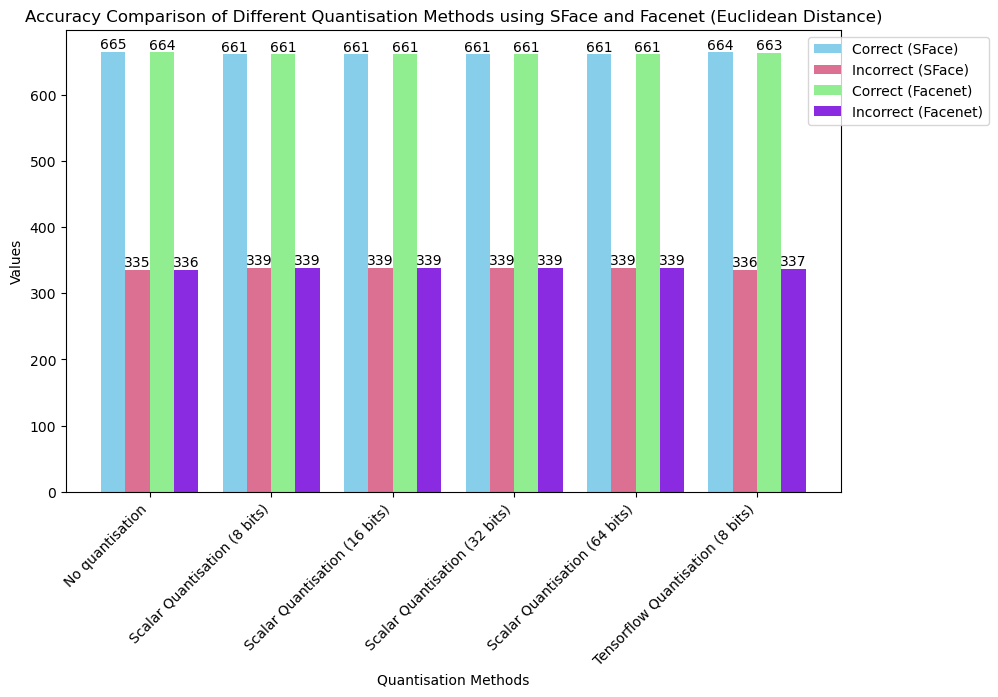

In [72]:
# Create visualisation for ED

# Data
methods = ['No quantisation', 'Scalar Quantisation (8 bits)', 'Scalar Quantisation (16 bits)', 'Scalar Quantisation (32 bits)', 'Scalar Quantisation (64 bits)', 'Tensorflow Quantisation (8 bits)']
correct_sface = correct_c
incorrect_sface = incorrect_c
correct_facenet = correct_f_c
incorrect_facenet = incorrect_f_c

# Number of methods
n_methods = len(methods)

# Position of bars on X axis
ind = np.arange(n_methods)

# Width of a bar 
width = 0.2       

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for SFace
bar1 = ax.bar(ind - width * 1.5, correct_sface, width, label='Correct (SFace)', color='skyblue')
bar2 = ax.bar(ind - width * 0.5, incorrect_sface, width, label='Incorrect (SFace)', color='palevioletred')

# Bar plots for Facenet
bar3 = ax.bar(ind + width * 0.5, correct_facenet, width, label='Correct (Facenet)', color='lightgreen')
bar4 = ax.bar(ind + width * 1.5, incorrect_facenet, width, label='Incorrect (Facenet)', color='blueviolet')

# Adding text labels for all bars
for bars in [bar1, bar2, bar3, bar4]:
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(int(bar.get_height())), ha='center', va='bottom')

# Labels, title and axes ticks
ax.set_xlabel('Quantisation Methods')
ax.set_ylabel('Values')
ax.set_title('Accuracy Comparison of Different Quantisation Methods using SFace and Facenet (Euclidean Distance)')
ax.set_xticks(ind)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Display the plot
plt.show()


In [63]:
#compare accuracies SFace Facenet cosine

m=1000 #number of pairs to compare 
c_t=0 #counter
w_t=0 #counter
c_s=0 #counter
w_s=0 #counter

c_s16=0 #counter
w_s16=0 #counter

c_s32=0 #counter
w_s32=0 #counter

c_s64=0 #counter
w_s64=0 #counter

c=0 #counter
w=0 #counter
c_t_s=0 #counter
w_t_s=0 #counter

c_s_s=0 #counter
w_s_s=0 #counter

c_s_s16=0 #counter
w_s_s16=0 #counter

c_s_s32=0 #counter
w_s_s32=0 #counter

c_s_s64=0 #counter
w_s_s64=0 #counter

c_s_s128=0 #counter
w_s_s128=0 #counter

c_ss=0 #counter
w_ss=0 #counter
fn_threshold_cos=0.4
sf_threshold_cos=0.593
fn_threshold=10
sf_threshold=10.734   
for i in range(0,m):
    print(i) #check if it is running
    n=random.choice([True, False])
    #facenet
    a, b, imga, imgb = get_two_random_embeddings_facenet(same_person=n)
    a_q_tensor=quantize_tensor(a)
    b_q_tensor=quantize_tensor(b)
    a_qn_t = a_q_tensor / np.linalg.norm(a_q_tensor)
    b_qn_t = b_q_tensor / np.linalg.norm(b_q_tensor)

    a_quant=scalar_quantization(a, 8, coverage)
    b_quant=scalar_quantization(b, 8, coverage)
    a_qn_s = a_quant / np.linalg.norm(a_quant)
    b_qn_s = b_quant / np.linalg.norm(b_quant)

    a_quant16=scalar_quantization(a, 16, coverage)
    b_quant16=scalar_quantization(b, 16, coverage)
    a_qn_s16 = a_quant16 / np.linalg.norm(a_quant16)
    b_qn_s16 = b_quant16 / np.linalg.norm(b_quant16)

    a_quant32=scalar_quantization(a, 32, coverage)
    b_quant32=scalar_quantization(b, 32, coverage)
    a_qn_s32 = a_quant32 / np.linalg.norm(a_quant32)
    b_qn_s32 = b_quant32 / np.linalg.norm(b_quant32)

    a_quant64=scalar_quantization(a, 64, coverage)
    b_quant64=scalar_quantization(b, 64, coverage)
    a_qn_s64 = a_quant64 / np.linalg.norm(a_quant64)
    b_qn_s64 = b_quant64 / np.linalg.norm(b_quant64)


    a_n=a / np.linalg.norm(a)
    b_n=b / np.linalg.norm(b)
    
    #sface
    a_s=get_embedding(imga)
    b_s=get_embedding(imgb)
    
    a_q_tensor_s=quantize_tensor(a_s)
    b_q_tensor_s=quantize_tensor(b_s)
    a_qn_t_s = a_q_tensor_s / np.linalg.norm(a_q_tensor_s)
    b_qn_t_s = b_q_tensor_s / np.linalg.norm(b_q_tensor_s)

    a_quant_s=scalar_quantization(a_s, 8, coverage)
    b_quant_s=scalar_quantization(b_s, 8, coverage)
    a_qn_s_s = a_quant_s / np.linalg.norm(a_quant)
    b_qn_s_s = b_quant_s / np.linalg.norm(b_quant)

    a_quant_s16=scalar_quantization(a_s, 16, coverage)
    b_quant_s16=scalar_quantization(b_s, 16, coverage)
    a_qn_s_s16 = a_quant_s16 / np.linalg.norm(a_quant16)
    b_qn_s_s16 = b_quant_s16 / np.linalg.norm(b_quant16)

    a_quant_s32=scalar_quantization(a_s, 32, coverage)
    b_quant_s32=scalar_quantization(b_s, 32, coverage)
    a_qn_s_s32= a_quant_s32 / np.linalg.norm(a_quant32)
    b_qn_s_s32 = b_quant_s32 / np.linalg.norm(b_quant32)

    a_quant_s64=scalar_quantization(a_s, 64, coverage)
    b_quant_s64=scalar_quantization(b_s, 64, coverage)
    a_qn_s_s64 = a_quant_s64 / np.linalg.norm(a_quant64)
    b_qn_s_s64 = b_quant_s64 / np.linalg.norm(b_quant64)


    a_n_s=a_s / np.linalg.norm(a_s)
    b_n_s=b_s / np.linalg.norm(b_s)
    
    if n==True:
        if get_cos_dist_numpy(a_qn_t, b_qn_t)>fn_threshold_cos:
            w_t=w_t+1
        else:
            c_t=c_t+1
        if get_cos_dist_numpy(a_qn_s, b_qn_s)>fn_threshold_cos:
            w_s=w_s+1
        else:
            c_s=c_s+1
        if get_cos_dist_numpy(a_qn_s16, b_qn_s16)>fn_threshold_cos:
            w_s16=w_s16+1
        else:
            c_s16=c_s16+1
        if get_cos_dist_numpy(a_qn_s32, b_qn_s32)>fn_threshold_cos:
            w_s32=w_s32+1
        else:
            c_s32=c_s32+1
        if get_cos_dist_numpy(a_qn_s64, b_qn_s64)>fn_threshold_cos:
            w_s64=w_s64+1
        else:
            c_s64=c_s64+1
        if get_cos_dist_numpy(a_n, b_n)>fn_threshold_cos:
            w=w+1
        else:
            c=c+1
    else:
        if get_cos_dist_numpy(a_qn_t, b_qn_t)>fn_threshold_cos:
            c_t=c_t+1
        else:
            w_t=w_t+1
        if get_cos_dist_numpy(a_qn_s, b_qn_s)>fn_threshold_cos:
            c_s=c_s+1
        else:
            w_s=w_s+1
        if get_cos_dist_numpy(a_qn_s16, b_qn_s16)<fn_threshold_cos:
            w_s16=w_s16+1
        else:
            c_s16=c_s16+1
        if get_cos_dist_numpy(a_qn_s32, b_qn_s32)<fn_threshold_cos:
            w_s32=w_s32+1
        else:
            c_s32=c_s32+1
        if get_cos_dist_numpy(a_qn_s64, b_qn_s64)<fn_threshold_cos:
            w_s64=w_s64+1
        else:
            c_s64=c_s64+1
        if get_cos_dist_numpy(a_n, b_n)>fn_threshold_cos:
            c=c+1
        else:
            w=w+1

    if n==True:
        if get_cos_dist_numpy(a_qn_t_s, b_qn_t_s)>sf_threshold_cos:
            w_t_s=w_t_s+1
        else:
            c_t_s=c_t_s+1
        if get_cos_dist_numpy(a_qn_s_s, b_qn_s_s)>sf_threshold_cos:
            w_s_s=w_s_s+1
        else:
            c_s_s=c_s_s+1
        if get_cos_dist_numpy(a_qn_s_s16, b_qn_s_s16)>sf_threshold_cos:
            w_s_s16=w_s_s16+1
        else:
            c_s_s16=c_s_s16+1
        if get_cos_dist_numpy(a_qn_s_s32, b_qn_s_s32)>sf_threshold_cos:
            w_s_s32=w_s_s32+1
        else:
            c_s_s32=c_s_s32+1
        if get_cos_dist_numpy(a_qn_s_s64, b_qn_s_s64)>sf_threshold_cos:
            w_s_s64=w_s_s64+1
        else:
            c_s_s64=c_s_s64+1
        if get_cos_dist_numpy(a_n_s, b_n_s)>sf_threshold_cos:
            w_ss=w_ss+1
        else:
            c_ss=c_ss+1
    else:
        if get_cos_dist_numpy(a_qn_t_s, b_qn_t_s)>sf_threshold_cos:
            c_t_s=c_t_s+1
        else:
            w_t_s=w_t_s+1
        if get_cos_dist_numpy(a_qn_s_s, b_qn_s_s)>sf_threshold_cos:
            c_s_s=c_s_s+1
        else:
            w_s_s=w_s_s+1
        if get_cos_dist_numpy(a_qn_s_s16, b_qn_s_s16)<sf_threshold_cos:
            w_s_s16=w_s_s16+1
        else:
            c_s_s16=c_s_s16+1
        if get_cos_dist_numpy(a_qn_s_s32, b_qn_s_s32)<sf_threshold_cos:
            w_s_s32=w_s_s32+1
        else:
            c_s_s32=c_s_s32+1
        if get_cos_dist_numpy(a_qn_s_s64, b_qn_s_s64)<sf_threshold_cos:
            w_s_s64=w_s_s64+1
        else:
            c_s_s64=c_s_s64+1
        if get_cos_dist_numpy(a_n_s, b_n_s)>sf_threshold_cos:
            c_ss=c_ss+1
        else:
            w_ss=w_ss+1

correct_f_c=[c,c_s, c_s16,c_s32,c_s64,c_t]
incorrect_f_c=[w,w_s, w_s16, w_s32,w_s64,w_t]
correct_c=[c_ss,c_s_s,c_s_s16,c_s_s32,c_s_s64,c_t_s]
incorrect_c=[w_ss,w_s_s,w_s_s16,w_s_s32,w_s_s64,w_t_s]

        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [64]:
print("facenet correct:", correct_f_c, "incorrect:", incorrect_f_c)
print("sface correct:", correct_c, "incorrect:", incorrect_c)

facenet correct: [869, 670, 670, 690, 690, 848] incorrect: [131, 330, 330, 310, 310, 152]
sface correct: [889, 670, 670, 734, 734, 871] incorrect: [111, 330, 330, 266, 266, 129]


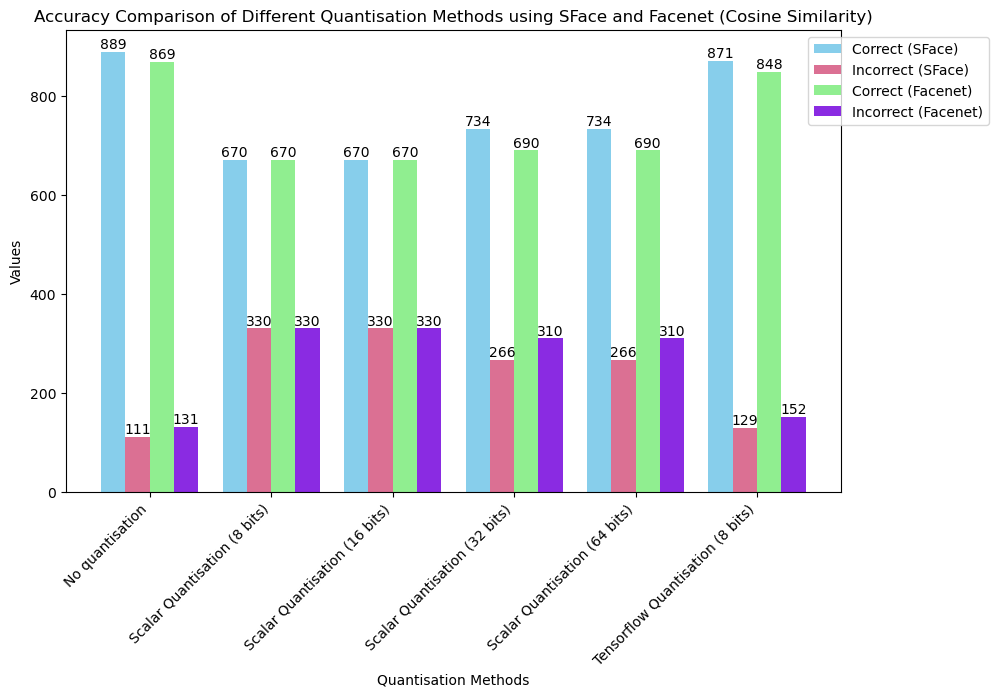

In [70]:
# Create visualisation for cos

# Data
methods = ['No quantisation', 'Scalar Quantisation (8 bits)', 'Scalar Quantisation (16 bits)', 'Scalar Quantisation (32 bits)', 'Scalar Quantisation (64 bits)', 'Tensorflow Quantisation (8 bits)']
correct_sface = correct_c
incorrect_sface = incorrect_c
correct_facenet = correct_f_c
incorrect_facenet = incorrect_f_c

# Number of methods
n_methods = len(methods)

# Position of bars on X axis
ind = np.arange(n_methods)

# Width of a bar 
width = 0.2       

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for SFace
bar1 = ax.bar(ind - width * 1.5, correct_sface, width, label='Correct (SFace)', color='skyblue')
bar2 = ax.bar(ind - width * 0.5, incorrect_sface, width, label='Incorrect (SFace)', color='palevioletred')

# Bar plots for Facenet
bar3 = ax.bar(ind + width * 0.5, correct_facenet, width, label='Correct (Facenet)', color='lightgreen')
bar4 = ax.bar(ind + width * 1.5, incorrect_facenet, width, label='Incorrect (Facenet)', color='blueviolet')

# Adding text labels for all bars
for bars in [bar1, bar2, bar3, bar4]:
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(int(bar.get_height())), ha='center', va='bottom')

# Labels, title and axes ticks
ax.set_xlabel('Quantisation Methods')
ax.set_ylabel('Values')
ax.set_title('Accuracy Comparison of Different Quantisation Methods using SFace and Facenet (Cosine Similarity)')
ax.set_xticks(ind)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Display the plot
plt.show()


below will be the functions to compare the execution time of (Facenet, SFace) x (Euclidean, Cosine) X (no quantisation, Tensorflow, scalar)

In [11]:
#facenet
#no quantisation
#cosine


n = 1000

# List to store execution times
execution_times_no_quantisation_facenet_cos = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a = a / np.linalg.norm(a)
    norm_emb_b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_no_quantisation_facenet_cos.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158


KeyboardInterrupt: 

In [ ]:
#facenet
#no quantisation
#euclidean


n = 1000

# List to store execution times
execution_times_no_quantisation_facenet_ed = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_no_quantisation_facenet_ed.append(execution_time)

In [ ]:
#facenet
#scalar quantisation
#cosine


n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos.append(execution_time)

In [ ]:
#facenet
#scalar quantisation
#euclidean


n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_ed = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_ed.append(execution_time)

In [ ]:
#facenet
#tensorflow quantisation
#cosine

n = 1000

# List to store execution times
execution_times_tensorflow_quantisation_facenet_cos = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=quantize_tensor(a)
    b=quantize_tensor(b)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_tensorflow_quantisation_facenet_cos.append(execution_time)

In [ ]:
#facenet
#tensorflow quantisation
#euclidean


n = 1000

# List to store execution times
execution_times_tensorflow_quantisation_facenet_ed = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=quantize_tensor(a)
    b=quantize_tensor(b)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_tensorflow_quantisation_facenet_ed.append(execution_time)

In [ ]:
#sface
#no quantisation
#cosine


n = 1000

# List to store execution times
execution_times_no_quantisation_sface_cos = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_no_quantisation_sface_cos.append(execution_time)

In [ ]:
#sface
#no quantisation
#euclidean


n = 1000

# List to store execution times
execution_times_no_quantisation_sface_ed = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_no_quantisation_sface_ed.append(execution_time)

In [ ]:
#sface
#scalar quantisation
#cosine


n = 1000
# List to store execution times
execution_times_scalar_quantisation_sface_cos = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_sface_cos.append(execution_time)

In [ ]:
#sface
#scalar quantisation
#euclidean


n = 1000

# List to store execution times
execution_times_scalar_quantisation_sface_ed = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_sface_ed.append(execution_time)

In [ ]:
#sface
#tensorflow quantisation
#cosine


n = 1000

# List to store execution times
execution_times_tensorflow_quantisation_sface_cos = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=quantize_tensor(a)
    b=quantize_tensor(b)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_tensorflow_quantisation_sface_cos.append(execution_time)

In [ ]:
#sface
#tensorflow quantisation
#euclidean


n = 1000

# List to store execution times
execution_times_tensorflow_quantisation_sface_ed = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=quantize_tensor(a)
    b=quantize_tensor(b)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_tensorflow_quantisation_sface_ed.append(execution_time)

Below is the code to draw to figures visualising the accuracy, one for facenet and one for sface

In [ ]:
n=1000
execution_times = (execution_times_no_quantisation_sface_cos + execution_times_no_quantisation_sface_ed +
                   execution_times_scalar_quantisation_sface_cos + execution_times_scalar_quantisation_sface_ed + 
                   execution_times_tensorflow_quantisation_sface_cos + execution_times_tensorflow_quantisation_sface_ed)

methods = (["No Quantisation, CS"] * n + 
           ["No Quantisation, ED"] * n + 
           ["Scalar Quantisation (32 bits), CS"] * n + 
           ["Scalar Quantisation (32 bits), ED"] * n + 
           ["Tensorflow Quantisation (8 bits), CS"] * n +
           ["Tensorflow Quantisation (8  bits), ED"] * n)

# Create a DataFrame
df = pd.DataFrame({"Execution Time (seconds)": execution_times, "Method": methods})

# Plot the violin plots
plt.figure(figsize=(20, 10))
sns.violinplot(x="Method", y="Execution Time (seconds)", data=df, inner=None, palette="muted")
sns.stripplot(x="Method", y="Execution Time (seconds)", data=df, color='red', alpha=0.5, jitter=0.1)

plt.title('Execution Time Distribution for Different Quantisation Methods using SFace')
plt.show()

In [ ]:
n=1000
execution_times = (execution_times_no_quantisation_facenet_cos + execution_times_no_quantisation_facenet_ed +
                   execution_times_scalar_quantisation_facenet_cos + execution_times_scalar_quantisation_facenet_ed + 
                   execution_times_tensorflow_quantisation_facenet_cos + execution_times_tensorflow_quantisation_facenet_ed)

methods = (["No Quantisation, CS"] * n + 
           ["No Quantisation, ED"] * n + 
           ["Scalar Quantisation (32 bits), CS"] * n + 
           ["Scalar Quantisation (32 bits), ED"] * n + 
           ["Tensorflow Quantisation (8 bits), CS"] * n +
           ["Tensorflow Quantisation (8  bits), ED"] * n)

# Create a DataFrame
df = pd.DataFrame({"Execution Time (seconds)": execution_times, "Method": methods})

# Plot the violin plots
plt.figure(figsize=(20, 10))
sns.violinplot(x="Method", y="Execution Time (seconds)", data=df, inner=None, palette="muted")
sns.stripplot(x="Method", y="Execution Time (seconds)", data=df, color='red', alpha=0.5, jitter=0.1)

plt.title('Execution Time Distribution for Different Quantisation Methods using FaceNet')
plt.show()

In [ ]:
avg_execution_times_no_quantisation_facenet_cos = statistics.mean(execution_times_no_quantisation_facenet_cos)
avg_execution_times_no_quantisation_facenet_ed = statistics.mean(execution_times_no_quantisation_facenet_ed)
avg_execution_times_scalar_quantisation_facenet_cos = statistics.mean(execution_times_scalar_quantisation_facenet_cos)
avg_execution_times_scalar_quantisation_facenet_ed = statistics.mean(execution_times_scalar_quantisation_facenet_ed)                  
avg_execution_times_tensorflow_quantisation_facenet_cos = statistics.mean(execution_times_tensorflow_quantisation_facenet_cos)
avg_execution_times_tensorflow_quantisation_facenet_ed = statistics.mean(execution_times_tensorflow_quantisation_facenet_ed)

In [ ]:
print("average execution times:")
print("no quantisation, facenet, cosine",avg_execution_times_no_quantisation_facenet_cos)
print("no quantisation, facenet, euclidean",avg_execution_times_no_quantisation_facenet_ed)
print("scalar quantisation, facenet, cosine",avg_execution_times_scalar_quantisation_facenet_cos)
print("scalar quantisation, facenet, euclidean",avg_execution_times_scalar_quantisation_facenet_ed)
print("tensorflow quantisation, facenet, cosine",avg_execution_times_tensorflow_quantisation_facenet_cos)
print("tensorflow quantisation, facenet, euclidean",avg_execution_times_tensorflow_quantisation_facenet_ed)

In [ ]:
avg_execution_times_no_quantisation_sface_cos = statistics.mean(execution_times_no_quantisation_sface_cos)
avg_execution_times_no_quantisation_sface_ed = statistics.mean(execution_times_no_quantisation_sface_ed)
avg_execution_times_scalar_quantisation_sface_cos = statistics.mean(execution_times_scalar_quantisation_sface_cos)
avg_execution_times_scalar_quantisation_sface_ed = statistics.mean(execution_times_scalar_quantisation_sface_ed)                  
avg_execution_times_tensorflow_quantisation_sface_cos = statistics.mean(execution_times_tensorflow_quantisation_sface_cos)
avg_execution_times_tensorflow_quantisation_sface_ed = statistics.mean(execution_times_tensorflow_quantisation_sface_ed)

In [ ]:
print("average execution times:")
print("no quantisation, sface, cosine",avg_execution_times_no_quantisation_sface_cos) 
print("no quantisation, sface, euclidean",avg_execution_times_no_quantisation_sface_ed)
print("scalar quantisation, sface, cosine",avg_execution_times_scalar_quantisation_sface_cos) 
print("scalar quantisation, sface, euclidean",avg_execution_times_scalar_quantisation_sface_ed)               
print("tensorflow quantisation, sface, cosine", avg_execution_times_tensorflow_quantisation_sface_cos) 
print("tensorflow quantisation, sface, euclidean",avg_execution_times_tensorflow_quantisation_sface_ed)

Below we compare the exectution times of scalar quantisation for different number of bits.

In [74]:
#facenet
#scalar quantisation
#cosine

bits=8
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos8 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos8.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [75]:
#facenet
#scalar quantisation
#cosine

bits=16
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos16 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos16.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [76]:
#facenet
#scalar quantisation
#cosine
bits=32

n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos32 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos32.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [77]:
#facenet
#scalar quantisation
#cosine

bits=64

n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos64 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos64.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [78]:
#sface
#scalar quantisation
#euclidean

bits=8
n = 1000

# List to store execution times
execution_times_scalar_quantisation_sface_ed8 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_sface_ed8.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [79]:
#sface
#scalar quantisation
#euclidean

bits=16
n = 1000

# List to store execution times
execution_times_scalar_quantisation_sface_ed16 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_sface_ed16.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [80]:
#sface
#scalar quantisation
#euclidean

bits=32
n = 1000

# List to store execution times
execution_times_scalar_quantisation_sface_ed32 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_sface_ed32.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [81]:
#sface
#scalar quantisation
#euclidean

bits=64
n = 1000

# List to store execution times
execution_times_scalar_quantisation_sface_ed64 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding(imga)
    b=get_embedding(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_sface_ed64.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [82]:
#facenet
#scalar quantisation
#euclidean

bits=8
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_ed8 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_ed8.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [83]:
#facenet
#scalar quantisation
#euclidean

bits=16
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_ed16 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_ed16.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [84]:
#facenet
#scalar quantisation
#euclidean

bits=32
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_ed32 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_ed32.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [85]:
#facenet
#scalar quantisation
#euclidean

bits=64
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_ed64 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    euclidean_distance(np.array(a),np.array(b))
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_ed64.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [86]:
#facenet
#scalar quantisation
#cosine

bits=8
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos8 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos8.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#facenet
#scalar quantisation
#cosine

bits=16
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos16 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos16.append(execution_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#facenet
#scalar quantisation
#cosine

bits=32
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos32 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos32.append(execution_time)

In [ ]:
#facenet
#scalar quantisation
#cosine

bits=64
n = 1000
# List to store execution times
execution_times_scalar_quantisation_facenet_cos64 = []

# Run the code n times
for _ in range(n): 
    print(_)
    same_person = random.choice([True, False])
    a,b,imga, imgb = get_two_random_embeddings(same_person=same_person)
    start_time = time.time()
    a=get_embedding_facenet(imga)
    b=get_embedding_facenet(imgb)
    a=scalar_quantization(a, bits, coverage)
    b=scalar_quantization(b, bits, coverage)
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    get_cos_dist_numpy(a,b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times_scalar_quantisation_facenet_cos64.append(execution_time)

In [ ]:
n=1000
execution_times = (execution_times_scalar_quantisation_facenet_cos8 + execution_times_scalar_quantisation_facenet_ed8 + 
                    execution_times_scalar_quantisation_facenet_cos16 + execution_times_scalar_quantisation_facenet_ed16 +
                  execution_times_scalar_quantisation_facenet_cos32 + execution_times_scalar_quantisation_facenet_ed32 +
                  execution_times_scalar_quantisation_facenet_cos64 + execution_times_scalar_quantisation_facenet_ed64)

methods = (["Scalar Quantisation (8 bits), CS"] * n + 
           ["Scalar Quantisation (8 bits), ED"] * n + 
           ["Scalar Quantisation (16 bits), CS"] * n + 
           ["Scalar Quantisation (16 bits), ED"] * n +
           ["Scalar Quantisation (32 bits), CS"] * n + 
           ["Scalar Quantisation (32 bits), ED"] * n +
           ["Scalar Quantisation (64 bits), CS"] * n + 
           ["Scalar Quantisation (64 bits), ED"] * n +
           )

# Create a DataFrame
df = pd.DataFrame({"Execution Time (seconds)": execution_times, "Method": methods})

# Plot the violin plots
plt.figure(figsize=(20, 10))
sns.violinplot(x="Method", y="Execution Time (seconds)", data=df, inner=None, palette="muted")
sns.stripplot(x="Method", y="Execution Time (seconds)", data=df, color='red', alpha=0.5, jitter=0.1)

plt.title('Execution Time Distribution for Scalar Quantisation using FaceNet')
plt.show()

In [ ]:
n=1000
execution_times = (execution_times_scalar_quantisation_sface_cos8 + execution_times_scalar_quantisation_sface_ed8 + 
                   execution_times_scalar_quantisation_sface_cos16 + execution_times_scalar_quantisation_sface_ed16 +
                  execution_times_scalar_quantisation_sface_cos32 + execution_times_scalar_quantisation_sface_ed32 +
                  execution_times_scalar_quantisation_sface_cos64 + execution_times_scalar_quantisation_sface_ed64)

methods = (["Scalar Quantisation (8 bits), CS"] * n + 
           ["Scalar Quantisation (8 bits), ED"] * n + 
           ["Scalar Quantisation (16 bits), CS"] * n + 
           ["Scalar Quantisation (16 bits), ED"] * n +
           ["Scalar Quantisation (32 bits), CS"] * n + 
           ["Scalar Quantisation (32 bits), ED"] * n +
           ["Scalar Quantisation (64 bits), CS"] * n + 
           ["Scalar Quantisation (64 bits), ED"] * n +
           )
# Create a DataFrame
df = pd.DataFrame({"Execution Time (seconds)": execution_times, "Method": methods})

# Plot the violin plots
plt.figure(figsize=(20, 10))
sns.violinplot(x="Method", y="Execution Time (seconds)", data=df, inner=None, palette="muted")
sns.stripplot(x="Method", y="Execution Time (seconds)", data=df, color='red', alpha=0.5, jitter=0.1)

plt.title('Execution Time Distribution for Scalar Quantisation using SFace')
plt.show()